# IMA pipeline tutorial

### by Patrick Kavanagh (DIAS, Ireland) June 20th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for IMA data in Python using the jwst step classes.

Documentation on each pipeline step can be found here:

http://ssb.stsci.edu/doc/jwst_dev/

The pipeline steps are:

2A: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting

2B: assign_wcs, flat_field, photom

The data file used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

In this notebook we will pass the step output to subsequent step input in datamodel form. The output from each step is also writting to a fits file.

#### imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from copy import deepcopy

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file, output directory for step outputs:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_steps_output'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input file. 
Note that ground test data and MIRISim data will differ here. We can distinguish between the two using the 'ORIGIN' header keyword. Converted ground test data will always have 'STScI' as the origin.

Also note that there is currently a problem running MIRISim data step-wise through the pipeline. One must remove some of the extensions. This has been taken care of in the following cell. This issue has been reported to STScI and this notebook will be updated when it is resolved.

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     144   ()      
  1  SCI         ImageHDU        14   (1032, 1024, 50, 2)   float32   
  2  REFOUT      ImageHDU        14   (258, 1024, 50, 2)   float32   
  3  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF        ImageHDU         7   (533678773,)   uint8   


## DQ_INIT step ===================================================
This step creates the PIXELDQ, GROUPDQ and ERR extensions in the ramp file 
which are copied from the calibration file. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/dq_init/index.html


### DQ_INIT: load module and show options

In [4]:
# import the step
from jwst.dq_init import dq_init_step

# print the description and options
print dq_init_step.DQInitStep.__doc__
print dq_init_step.DQInitStep.spec




    DQInitStep:  Initialize the Data Quality extension from the
    mask reference file.  Also initialize the error extension

    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    


### DQ_INIT: run step

In [5]:
# run the dq_init step
dm = dq_init_step.DQInitStep.call(input_files[0], save_results=True, output_dir=output_dir, output_file='dq_init_out.fits')

2017-06-28 21:47:26,861 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2017-06-28 21:47:40,561 - stpipe.DQInitStep - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits'.
2017-06-28 21:47:40,727 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits',).
2017-06-28 21:47:43,507 - stpipe.DQInitStep - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits
2017-06-28 21:47:53,307 - stpipe.DQInitStep - INFO - Saving file IMA_demo_data_steps_output/dq_init_out.fits
2017-06-28 21:47:54,983 - stpipe.DQInitStep - INFO - Step DQInitStep done


### DQ_INIT:  output check

1. check the output datamodel to show values in the new extensions, check that some pixels have been assigned new flags from the mask file

In [6]:
# check the calibration step information
print'Check dq_init step information status:'
print dm.meta.cal_step.dq_init

# print unique values in the PIXELDQ extension
print "\nDQ flags values in PIXELDQ:"
print ', '.join(map(str, np.unique(dm.pixeldq)))

# print unique values in the GROUPDQ extension
print "\nDQ flags values in GROUPDQ extension:"
print ', '.join(map(str, np.unique(dm.groupdq)))

Check dq_init step information status:
COMPLETE

DQ flags values in PIXELDQ:
0, 512, 1025, 2049, 16385, 16777216, 16777217, 16777729

DQ flags values in GROUPDQ extension:
0


### DQ_INIT:  output plots

1. plot the science data

2. plot the PIXEL_DQ extension to show which pixels have been flagged

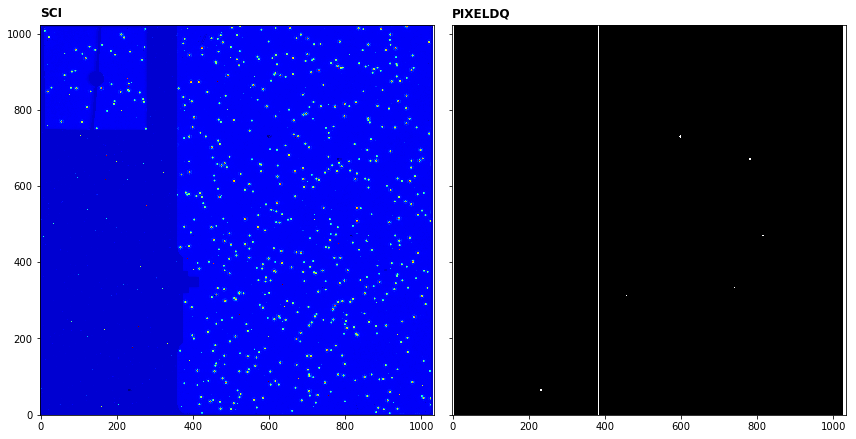

In [7]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the PIXEL_DQ frame
axs[1].imshow(dm.pixeldq, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## SATURATION step ============================================
The saturation step flags saturated pixel for each integration by reading the calibration reference
file that specifies the saturation level for each pixel. The saturation flags are set in the fram of the GROUPDQ extension where the pixel reaches saturation. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/saturation/index.html


### SATURATION: load module and show options

In [8]:
# import the step
from jwst.saturation import saturation_step

# print the description and options
print saturation_step.SaturationStep.__doc__
print saturation_step.SaturationStep.spec



    This Step sets saturation flags.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    


### SATURATION: run step

In [9]:
# run the saturation step
dm = saturation_step.SaturationStep.call(dm, save_results=True, output_dir=output_dir, output_file='saturation_out.fits')

2017-06-28 21:48:08,938 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2017-06-28 21:48:11,759 - stpipe.SaturationStep - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0019.fits'.
2017-06-28 21:48:11,940 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x1fae49dd0>,).
2017-06-28 21:48:14,836 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0019.fits
2017-06-28 21:48:16,329 - stpipe.SaturationStep - INFO - Saving file IMA_demo_data_steps_output/saturation_out.fits
2017-06-28 21:48:18,853 - stpipe.SaturationStep - INFO - Step SaturationStep done


### SATURATION:  output check

1. saturated pixels will be flagged in the GROUPDQ extension with the number 2. Check that some pixels in this extension are now flagged as saturated

In [10]:
# check the calibration step information
print'Check saturation step information status:'
print dm.meta.cal_step.saturation

# print unique values in the GROUPDQ extension
print "\nDQ flags values in GROUPDQ extension:"
print ', '.join(map(str, np.unique(dm.groupdq)))
    

Check saturation step information status:
COMPLETE

DQ flags values in GROUPDQ extension:
0, 2


### SATURATION:  output plots

1. plot the science data

2. plot the GROUP_DQ extension to show which pixels have been flagged as saturated

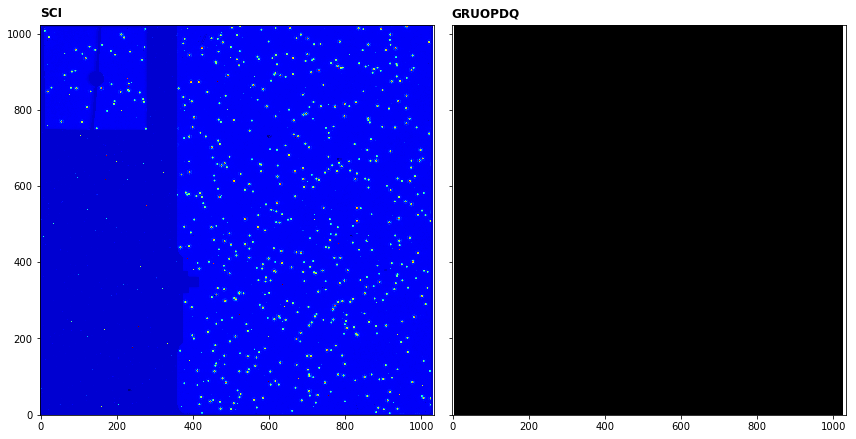

In [11]:
# plot--------------------------------------   
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot last frame of first integration GROUP_DQ
axs[1].imshow(np.sum(dm.groupdq[0],axis=0), cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('GRUOPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## LINEARITY step ===============================================

This step corrects for detector non-linearity. The linearity coefficients are read from the linearity correction reference file.

http://ssb.stsci.edu/doc/jwst_dev/jwst/linearity/index.html


### LINEARITY: load module and show options

In [12]:
# import the step
from jwst.linearity import linearity_step

# print the description and options
print linearity_step.LinearityStep.__doc__
print linearity_step.LinearityStep.spec

# copy the datamodel for input/output comparison
in_dm = deepcopy(dm)


    LinearityStep: This step performs a correction for non-linear
    detector response, using the "classic" polynomial method.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    


### LINEARITY: run step

In [13]:
# run the linearity step
dm = linearity_step.LinearityStep.call(dm, save_results=True, output_dir=output_dir, output_file='linearity_out.fits')

2017-06-28 21:48:36,618 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2017-06-28 21:48:39,092 - stpipe.LinearityStep - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2017-06-28 21:48:39,277 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11b1a8150>,).
2017-06-28 21:48:41,605 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits
2017-06-28 21:48:43,750 - stpipe.LinearityStep - INFO - Saving file IMA_demo_data_steps_output/linearity_out.fits
2017-06-28 21:48:45,761 - stpipe.LinearityStep - INFO - Step LinearityStep done


### LINEARITY:  plot output science image to select pixel for inspection

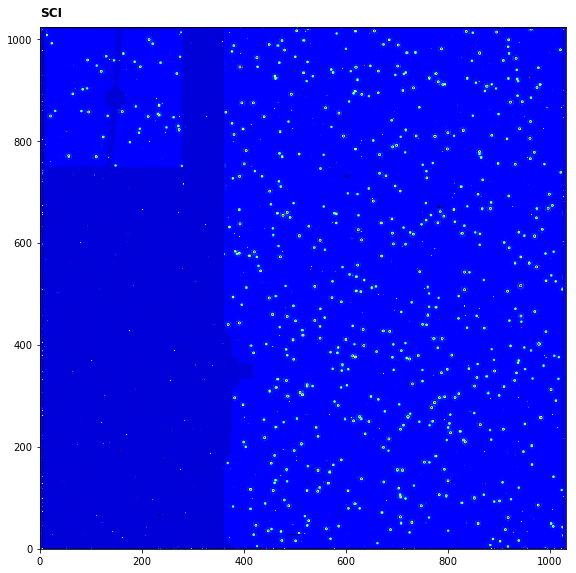

In [14]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### LINEARITY:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these

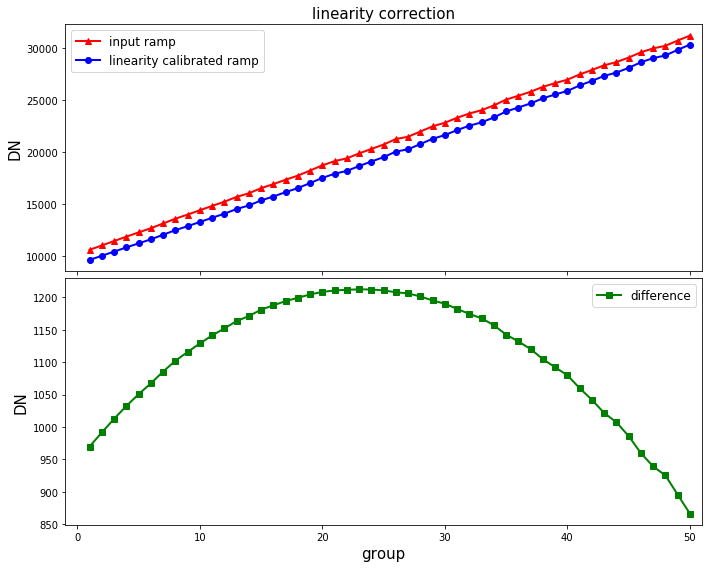

In [15]:
# using image in previous cell, select pixel to check
pixel = [623,558]

# define group numbers for integration ramps
group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='linearity calibrated ramp')
axs[0].set_title('linearity correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



## RSCD step ======================================================
This step corrects for the slow adjustment of the reset FET to the asymtotic level after reset. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/rscd/index.html


### RSCD: load module and show options

In [16]:
# import the step
from jwst.rscd import rscd_step

# print the description and options
print rscd_step.RSCD_Step.__doc__
print rscd_step.RSCD_Step.spec

# copy the datamodel for input/output comparison
in_dm = deepcopy(dm)


    RSCD_Step: Performs an RSCD correction to MIRI data by adding a function
    of time, frame by frame, to a copy of the input science data model.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    


#### RSCD: run step

In [17]:
# run the rscd step
dm = rscd_step.RSCD_Step.call(dm, save_results=True, output_dir=output_dir, output_file='rscd_out.fits')

2017-06-28 21:48:58,720 - stpipe.RSCD_Step - INFO - RSCD_Step instance created.
2017-06-28 21:49:01,552 - stpipe.RSCD_Step - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0004.fits'.
2017-06-28 21:49:01,733 - stpipe.RSCD_Step - INFO - Step RSCD_Step running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x1fab2a890>,).
2017-06-28 21:49:04,131 - stpipe.RSCD_Step - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0004.fits
2017-06-28 21:49:36,198 - stpipe.RSCD_Step - INFO - Saving file IMA_demo_data_steps_output/rscd_out.fits
2017-06-28 21:49:38,271 - stpipe.RSCD_Step - INFO - Step RSCD_Step done


### RSCD:  plot output science image to select pixel for inspection

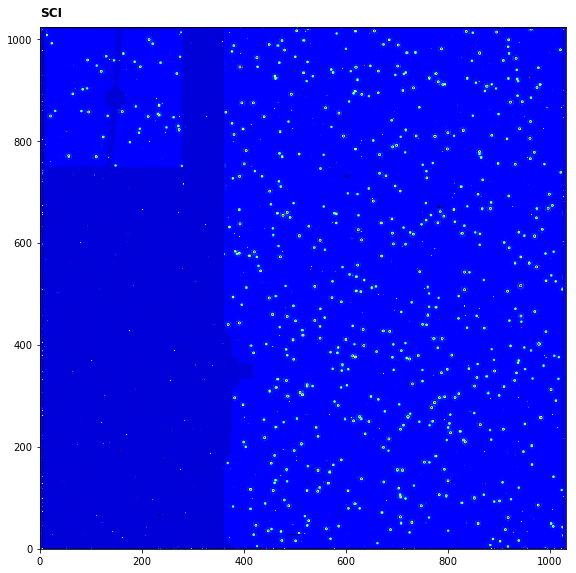

In [18]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### RSCD:  input/output ramp comparison

1. plot the input and output ramps. Note that the RSCD step only corrects following a reset show will note perform a correction if there is only one integration in the exposure.

2. show the difference between the input and output ramps


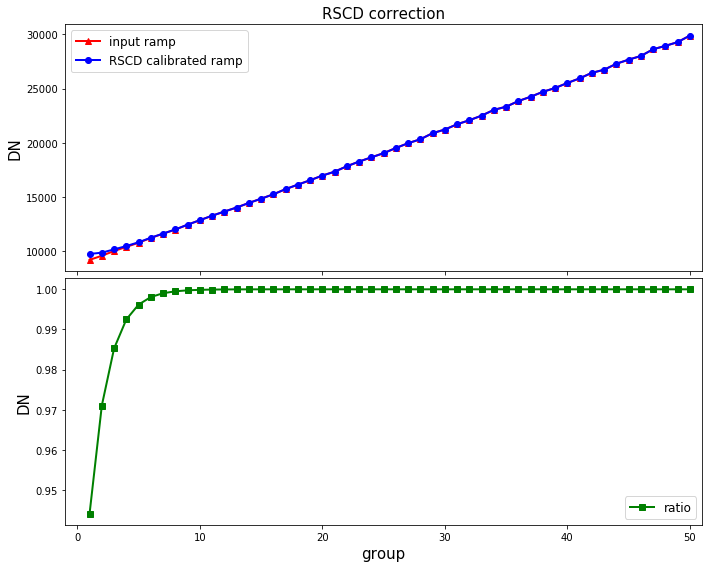

In [19]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

   
# first check that there is more than one integration
if in_dm.data.shape[0] > 1:

    # plot--------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # plot input and output ramps of the second integration
    axs[0].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
    axs[0].plot(group, dm.data[-1,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='RSCD calibrated ramp')
    axs[0].set_title('RSCD correction',fontsize=15)
    axs[0].set_ylabel('DN',fontsize=15)
    axs[0].set_xlim(-1,max(group)+1)
    axs[0].legend(prop={'size':12}, loc=0)

    # plot ratio between the two
    axs[1].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]] / dm.data[-1,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='ratio')
    axs[1].set_ylabel('DN',fontsize=15)
    axs[1].set_xlabel('group',fontsize=15)
    axs[1].legend(prop={'size':12}, loc=0)

    plt.tight_layout(h_pad=0)
    plt.show()

else: print "RSCD step only operates on exposures with more than one integration."


## LASTFRAME step ==========================================
This step corrects for the anonolous offsets in the last frame of an integration due to the way MIRI detectors reset sequentially. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/rscd/index.html


### LASTFRAME: load module and show options

In [20]:
# import the step
from jwst.lastframe import lastframe_step

# print the description and options
print lastframe_step.LastFrameStep.__doc__
print lastframe_step.LastFrameStep.spec

# copy the datamodel for input/output comparison
in_dm = deepcopy(dm)


    LastFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 1, the GROUP data quality flags for the final group will
    be set to DO_NOT_USE.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    


### LASTFRAME: run step

In [21]:
# run the lastframe step
dm = lastframe_step.LastFrameStep.call(dm, save_results=True, output_dir=output_dir, output_file='lastframe_out.fits')

2017-06-28 21:49:58,682 - stpipe.LastFrameStep - INFO - LastFrameStep instance created.
2017-06-28 21:49:59,443 - stpipe.LastFrameStep - INFO - Step LastFrameStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16d8e7090>,).
2017-06-28 21:50:01,419 - stpipe.LastFrameStep - INFO - Saving file IMA_demo_data_steps_output/lastframe_out.fits
2017-06-28 21:50:03,339 - stpipe.LastFrameStep - INFO - Step LastFrameStep done


### LASTFRAME:  input/output ramp comparison

This correction flags the last frame of an integration so we can check that the last frame has indeed been flagged in the groupDQ extension.

1. plot the last frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that last frame has been flagged

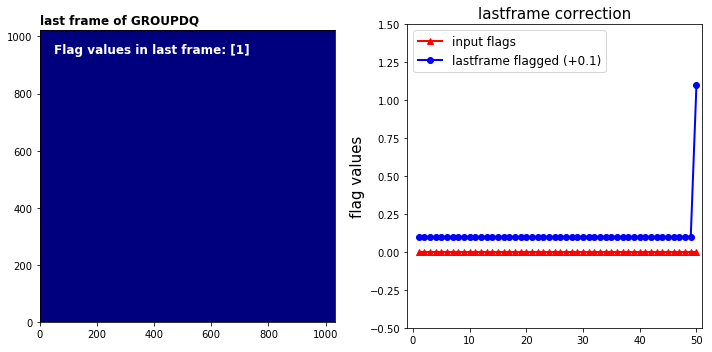

In [22]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the last frame of the first integration of the GROUPDQ extension
axs[0].imshow(dm.groupdq[-1][-1], cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('last frame of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# determine the values in this GROUPDQ frame
flag_values = np.unique(dm.groupdq[-1][-1])
axs[0].annotate('Flag values in last frame: %s' % flag_values, xy=(0.05, 0.92), xycoords='axes fraction', fontsize=12, fontweight='bold', color='w')

# input and output ramps (setting a slight offset for the output ramp)
axs[1].plot(group, in_dm.groupdq[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[-1,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='lastframe flagged (+0.1)')
axs[1].set_title('lastframe correction',fontsize=15)
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,1.5)
axs[1].legend(prop={'size':12}, loc=2)

plt.tight_layout(h_pad=0)
plt.show()



## DARK_CURRENT step ==========================================

This step removes the dark current by subtracting a dark current reference file.

http://ssb.stsci.edu/doc/jwst_dev/jwst/dark_current/index.html

Note that since a dark_current was not included in the MIRISim simulations that produced the demo data, we will skip the dark_current step.

### DARK_CURRENT: load module and show options

In [23]:
# import the step
from jwst.dark_current import dark_current_step

# print the description and options
print dark_current_step.DarkCurrentStep.__doc__
print dark_current_step.DarkCurrentStep.spec

# copy the datamodel for input/output comparison
in_dm = deepcopy(dm)


    DarkCurrentStep: Performs dark current correction by subtracting
    dark current reference data from the input science data model.
    

        dark_output = output_file(default = None)
    


### DARK_CURRENT: run step

In [24]:
# run the dark_current step
dm = dark_current_step.DarkCurrentStep.call(dm, save_results=True, output_dir=output_dir, output_file='dark_current_out.fits', skip=True)

2017-06-28 21:50:10,966 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2017-06-28 21:50:11,587 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11c240ed0>,).
2017-06-28 21:50:11,588 - stpipe.DarkCurrentStep - INFO - Step skipped.
2017-06-28 21:50:11,600 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep done


### DARK_CURRENT:  plot output science image to select pixel for inspection

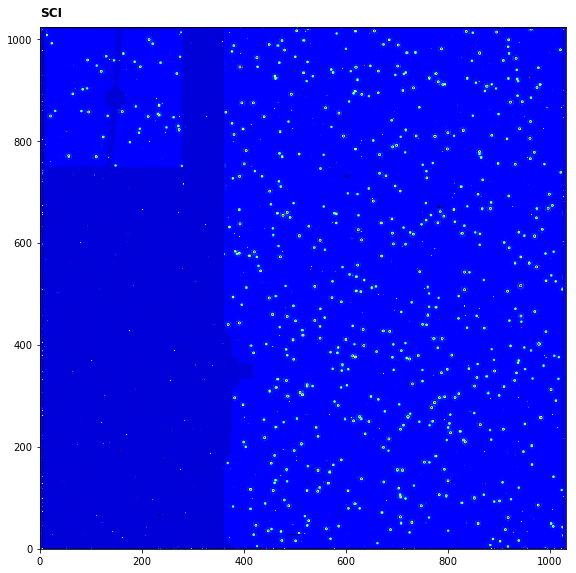

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### DARK_CURRENT:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


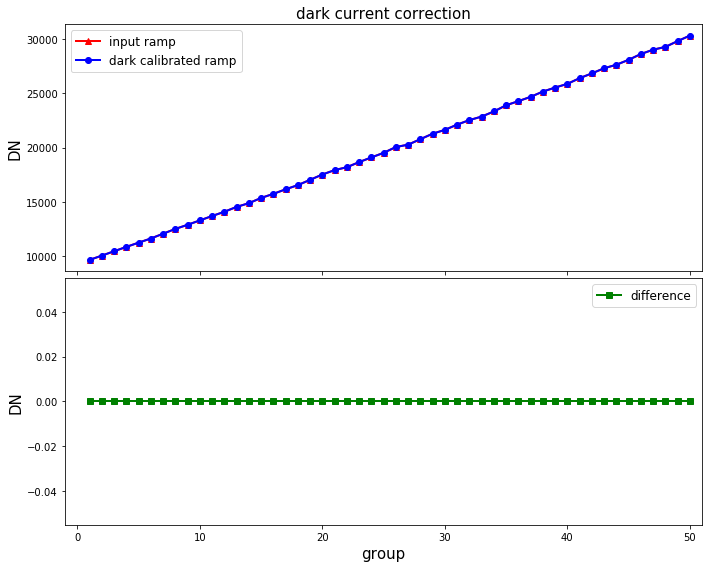

In [26]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='dark calibrated ramp')
axs[0].set_title('dark current correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## REFPIX step =============================================
This step corrects for electronic drift effects in the data by applying the reference pixel correction. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/refpix/index.html


### REFPIX: load module and show options

In [27]:
# import the step
from jwst.refpix import refpix_step

# print the description and options
print refpix_step.RefPixStep.__doc__
print refpix_step.RefPixStep.spec

# copy the datamodel for input/output comparison
in_dm = deepcopy(dm)



    RefPixStep: Use reference pixels to correct bias drifts

    

        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


### REFPIX: run step

In [28]:
# run the refpix step
dm = refpix_step.RefPixStep.call(dm, save_results=True, output_dir=output_dir, output_file='refpix_out.fits')

2017-06-28 21:50:19,061 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2017-06-28 21:50:21,382 - stpipe.RefPixStep - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-06-28 21:50:21,564 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11c240ed0>,).
2017-06-28 21:50:22,518 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2017-06-28 21:50:22,519 - stpipe.RefPixStep - INFO - odd_even_columns = True
2017-06-28 21:50:22,521 - stpipe.RefPixStep - INFO - side_smoothing_length = 11
2017-06-28 21:50:22,522 - stpipe.RefPixStep - INFO - side_gain = 1.000000
2017-06-28 21:50:22,523 - stpipe.RefPixStep - INFO - odd_even_rows = True
2017-06-28 21:50:22,524 - stpipe.RefPixStep - INFO - Subtracting initial read from each integration
2017-06-28 21:50:23,928 - stpipe.RefPixStep - INFO - Adding initial read back in
2017-06-28 21:50:27,262 - stpipe.RefPixStep - INFO - Saving file IMA_demo_data_steps_output/refpix_

### REFPIX:  plot output science image to select pixel for inspection

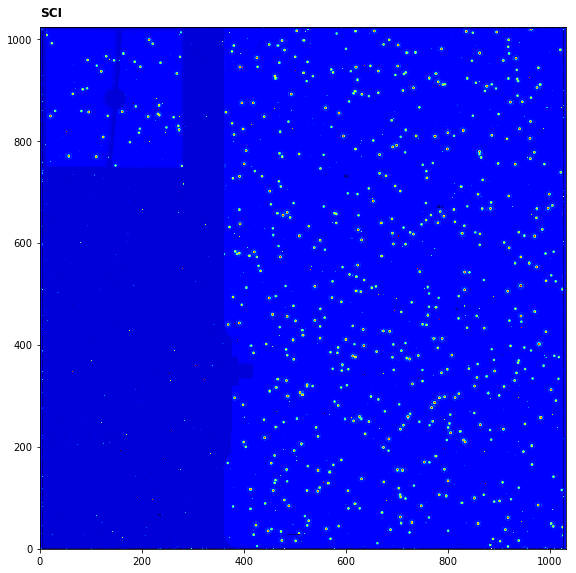

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### REFPIX:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


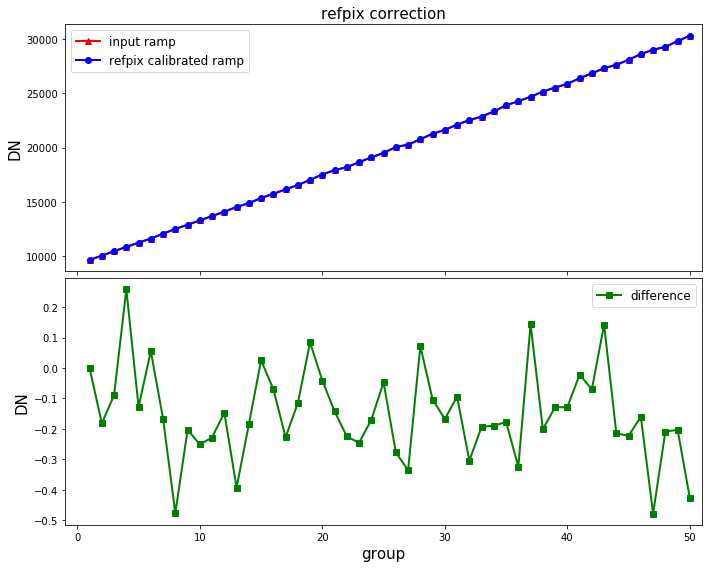

In [30]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]


# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='refpix calibrated ramp')
axs[0].set_title('refpix correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## JUMP correction =================================================

This step detects jumps in the ramp by looking for outliers from the ramp. It updates the GROUPDQ array to indicate where a jump was found.

http://ssb.stsci.edu/doc/jwst_dev/jwst/jump/index.html


### JUMP: load module and show options

In [31]:
# import the step
from jwst.jump import jump_step

# print the description and options
print jump_step.JumpStep.__doc__
print jump_step.JumpStep.spec

# copy the datamodel for input/output comparison
in_dm = deepcopy(dm)


    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied.
    

        rejection_threshold = float(default=4.0,min=0) # CR rejection threshold
    


### JUMP: run step

In [32]:
# run the jump step
dm = jump_step.JumpStep.call(dm, save_results=True, output_dir=output_dir, output_file='jump_out.fits')

2017-06-28 21:51:04,024 - stpipe.JumpStep - INFO - JumpStep instance created.
2017-06-28 21:51:06,943 - stpipe.JumpStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-06-28 21:51:06,944 - stpipe.JumpStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-06-28 21:51:07,146 - stpipe.JumpStep - INFO - Step JumpStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x168f0e510>,).
2017-06-28 21:51:08,076 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2017-06-28 21:51:09,575 - stpipe.JumpStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-06-28 21:51:10,952 - stpipe.JumpStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-06

### JUMP:  plot output science image to select pixel for inspection

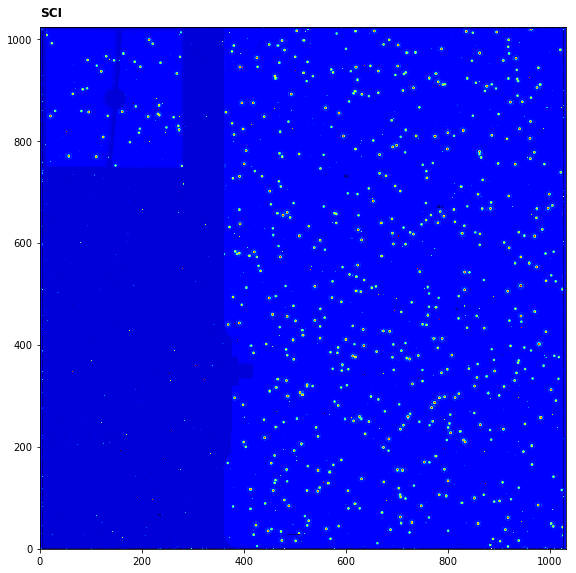

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### JUMP:  input/output ramp comparison

1. plot the output ramp

2. show the input and output GROUPDQ vectors and mark where jumps were detected (a flag of >=4 in GROUPDQ)


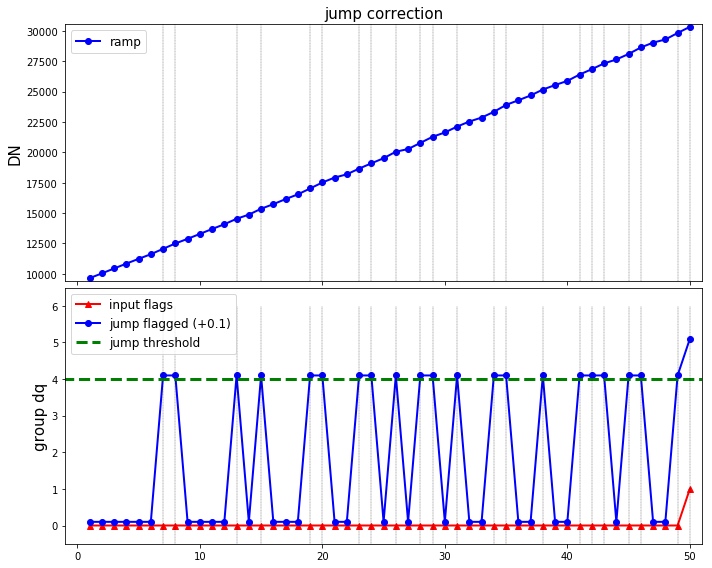

In [34]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# first integration for input/output ramps
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='ramp')
axs[0].set_title('jump correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].set_ylim(min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200)
axs[0].legend(prop={'size':12}, loc=2)

# input and output flag values (setting a slight offset for the output flags)
axs[1].plot(group, in_dm.groupdq[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[0,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='jump flagged (+0.1)')
axs[1].plot([-10,100],[4,4], linestyle='--', linewidth=3, c='g', label='jump threshold')
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_ylabel('group dq',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,6.5)
axs[1].legend(prop={'size':12}, loc=2)

# draw lines to show the groups which have been flagged as jumps
for n, val in enumerate(group):
    if (dm.groupdq[0,n,pixel[1],pixel[0]] >= 4): 
        axs[0].plot([n+1,n+1],[min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200], linestyle='--', linewidth=0.3, c='k')
        axs[1].plot([n+1,n+1],[-1,6], linestyle='--', linewidth=0.3, c='k')

plt.tight_layout(h_pad=0)
plt.show()


## RAMP_FITTING step =========================================

This step caculates the mean count rate for each pixel by performing a linear fit to the ramps. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/ramp_fitting/index.html

There are two outputs are here:

1) the slope image  (_rate.fits)

2) if more than one integration, slope image per integration  (_rateints.fits)


### RAMP_FITTING: load module and show options

In [35]:
# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print ramp_fit_step.RampFitStep.__doc__
print ramp_fit_step.RampFitStep.spec



    This step fits a straight line to the value of counts vs. time to
    determine the mean count rate for each pixel.
    

        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')

    


### RAMP_FITTING: run step

In [36]:
# run the ramp_fitting step
dm = ramp_fit_step.RampFitStep.call(dm, save_results=True, output_dir=output_dir)

# copy datamodel for comparison later
level2A_dm = deepcopy(dm)

2017-06-28 21:53:47,472 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2017-06-28 21:53:50,227 - stpipe.RampFitStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-06-28 21:53:50,228 - stpipe.RampFitStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-06-28 21:53:50,421 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x141156890>,).
2017-06-28 21:53:54,088 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-06-28 21:53:54,123 - stpipe.RampFitStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-06-28 21:53:54,151 - stpipe.RampFitStep - INFO - Using algorit

### RAMP_FITTING:  level 1B and level 2A image comparison

Visually compare the input ramp and the output slope image

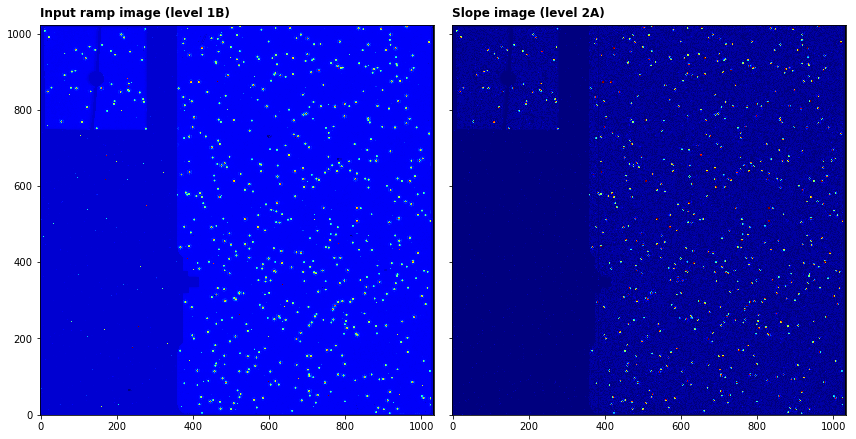

In [37]:
# open the level 1B input as a jwst data model
with datamodels.open(input_files[0]) as in_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # sum the groups in the first integration of the input ramp image and plot
    axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
    axs[0].annotate('Input ramp image (level 1B)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
    axs[1].annotate('Slope image (level 2A)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()
    

## ASSIGN_WCS step =================================================
This step creates a WCS object and associates it with the science file, mapping detector to world coordinates. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/assign_wcs/index.html


In [38]:
# import the step
from jwst.assign_wcs import assign_wcs_step

# print the description and options
print assign_wcs_step.AssignWcsStep.__doc__
print assign_wcs_step.AssignWcsStep.spec



    AssignWcsStep: Loads all WCS and distortion information for an exposure
    and stores it in the model meta data.
    

    


### ASSIGN_WCS: run step

In [39]:
# run the assign_wcs step
dm = assign_wcs_step.AssignWcsStep.call(dm, save_results=True, output_dir=output_dir, output_file='assign_wcs_out.fits')

2017-06-28 21:59:13,097 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2017-06-28 21:59:14,167 - stpipe.AssignWcsStep - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-06-28 21:59:14,168 - stpipe.AssignWcsStep - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-06-28 21:59:14,169 - stpipe.AssignWcsStep - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-06-28 21:59:14,169 - stpipe.AssignWcsStep - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf'.
2017-06-28 21:59:14,170 - stpipe.AssignWcsStep - INFO - Prefetch for FILTEROFFSET reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_filteroffset_0003.asdf'.
2017-06-28 21:59:14,171 - stpipe.AssignWcsStep - INFO - Prefetch for FORE reference file is 'N/A'.
2017-06-28 21:59:14,172 - stpipe.AssignWcsStep - INFO - Prefetch for FPA reference file is 'N/A'.
2017-06-28 21:59:14,173 -

### ASSIGN_WCS:  plot output science image to select pixel for inspection

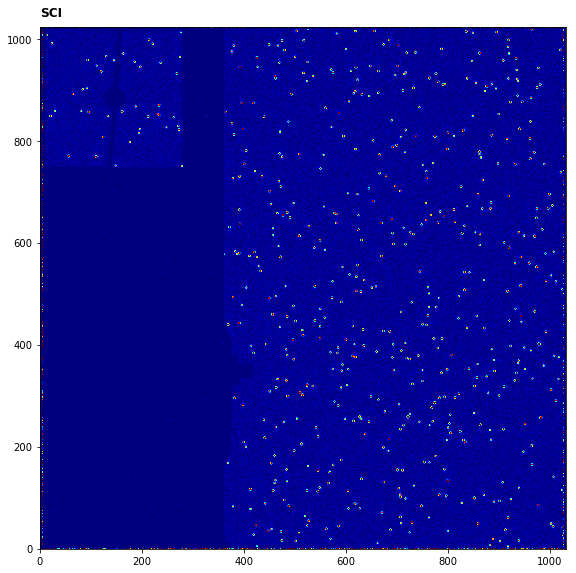

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### ASSIGN_WCS: perform some transforms

1. Display the available coordinate frames

2. perform some transfer from pixel to WCS

In [41]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# print available coordinate frames
print "Available coordinate frames:" 
print(", ".join(dm.meta.wcs.available_frames))
print ""

# perform transforms on pixel
ra, dec = dm.meta.wcs(pixel[0],pixel[1])

print "Pixel: %d, %d" % (pixel[0],pixel[1])
print "assign_wcs RA, DEC (deg): %0.7f %0.7f" % (ra,dec)


Available coordinate frames:
detector, v2v3, world

Pixel: 623, 558
assign_wcs RA, DEC (deg): 0.0027863 0.0000769


## FLAT_FIELD step =============================================
The flat_field step divides the image by a flat-field reference image and updates the DQ array to indicate where no flat-field is available for a pixel. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/flatfield/index.html


### FLAT_FIELD: load module and show options

In [42]:
# import the step
from jwst.flatfield import flat_field_step

# print the description and options
print flat_field_step.FlatFieldStep.__doc__
print flat_field_step.FlatFieldStep.spec

# copy the datamodel for input/output comparison
in_dm = deepcopy(dm)


    FlatFieldStep: Flat-field a science image using a flatfield reference image.
    

        # Suffix for optional output file for interpolated flat fields.
        # Note that this is only used for NIRSpec spectrographic data.
        flat_suffix = string(default=None)
    


### FLAT_FIELD: run step

In [43]:
# run the flat_field step
dm = flat_field_step.FlatFieldStep.call(dm, save_results=True, output_dir=output_dir, output_file='flatfield_out.fits')

2017-06-28 21:59:33,401 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2017-06-28 21:59:34,337 - stpipe.FlatFieldStep - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-06-28 21:59:34,338 - stpipe.FlatFieldStep - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-06-28 21:59:34,339 - stpipe.FlatFieldStep - INFO - Prefetch for FLAT reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_flat_0123.fits'.
2017-06-28 21:59:34,339 - stpipe.FlatFieldStep - INFO - Prefetch for SFLAT reference file is 'N/A'.
2017-06-28 21:59:34,423 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<jwst.datamodels.image.ImageModel object at 0x11bff8110>,).
2017-06-28 21:59:35,279 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-06-28 21:59:35,280 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so 

### FLAT_FIELD: input/output image checks

1. Display the input and output images
2. Show the ratio of the two

2017-06-28 21:59:40,861 - stpipe - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7rc1/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide



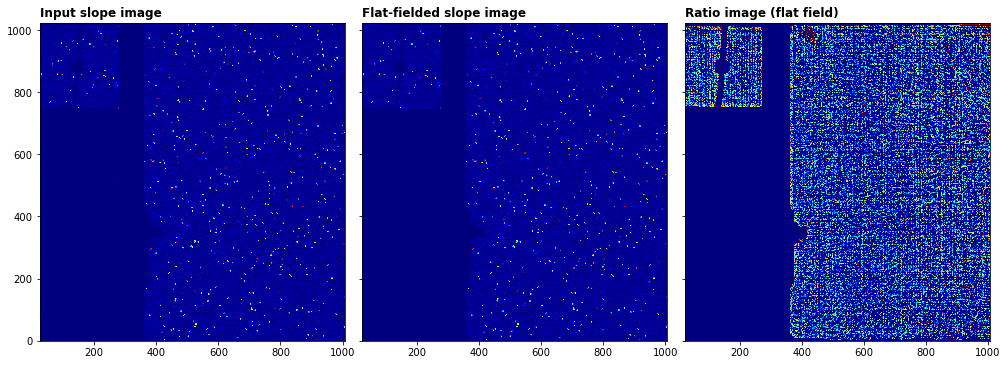

In [44]:
# plot--------------------------------------
# show the input, output and ratio image, 
# which will correspond to the flat field.
fig, axs = plt.subplots(1, 3, figsize=(14, 5),sharey=True)

# show the input
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
axs[0].annotate('Input slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')

axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
axs[1].annotate('Flat-fielded slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

axs[2].imshow(in_dm.data / dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1.00, vmax=1.01)
axs[2].annotate('Ratio image (flat field)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].set_facecolor('black')

plt.tight_layout()
plt.show()

## PHOTOM step =======================================
This step uses spectroscopic photometric conversion reference files to convert count rates to absolute flux units. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/photom/index.html

This is the last step in the level 2b pipeline.

### PHOTOM: load module and show options

In [45]:
# import the step
from jwst.photom import photom_step

# print the description and options
print photom_step.PhotomStep.__doc__
print photom_step.PhotomStep.spec



    PhotomStep: Module for loading photometric conversion infomation from
        reference files and attaching or applying them to the input science
        data model
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    


### PHOTOM: run step

In [46]:
dm = photom_step.PhotomStep.call(dm, save_results=True, output_dir=output_dir, output_file='photom_out.fits')

2017-06-28 21:59:46,740 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2017-06-28 21:59:47,619 - stpipe.PhotomStep - INFO - Prefetch for AREA reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits'.
2017-06-28 21:59:47,620 - stpipe.PhotomStep - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits'.
2017-06-28 21:59:47,703 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<jwst.datamodels.image.ImageModel object at 0x17ab2f890>,).
2017-06-28 21:59:48,459 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits
2017-06-28 21:59:48,965 - stpipe.PhotomStep - INFO - Using area reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits
2017-06-28 21:59:48,966 - stpipe.PhotomStep - INFO - Using instrument: MIRI
2017-06-28 21:59:4

### PHOTOM: check the correct photometric keywords in output header

1. Get the photometric information from the output header

In [47]:
print "Photometric conversions (Flux density producing 1 cps)"
print "%0.2e microJy/arcsec^2" % dm.meta.photometry.conversion_microjanskys
print "%0.2e MJy/sr" % dm.meta.photometry.conversion_megajanskys


Photometric conversions (Flux density producing 1 cps)
5.76e+01 microJy/arcsec^2
2.45e+00 MJy/sr


### FINAL OUTPUT CHECKS =======================================

The level 2B file is the calibrated slope product. We can show the evolution of the data through 1B - 2A - 2B stages

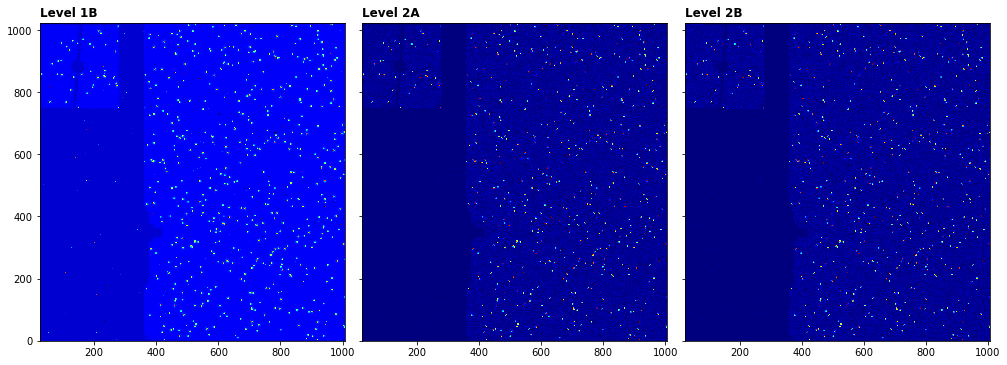

In [48]:
# open the input and output image as jwst data models
with datamodels.open(input_files[0]) as lvl1b_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

    # 1B image
    axs[0].imshow(lvl1b_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
    axs[0].annotate('Level 1B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')

    # 2A image
    axs[1].imshow(level2A_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
    axs[1].annotate('Level 2A', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

    # 2B image
    axs[2].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
    axs[2].annotate('Level 2B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[2].set_facecolor('black')

    plt.tight_layout()
    plt.show()